# National Liberal Arts Colleges Data

- **Author:** Cameron Raymond
- **Affliation:** University of Oxford, Oxford Internet Institute
- **Program:** MSc, Social Data Science
- **Email:** [cameron.raymond@hey.com](mailto:cameron.raymond@hey.com)

Scraping the 2021 rankings from the National Liberal Arts Colleges rankings: https://www.usnews.com/best-colleges/rankings/national-liberal-arts-colleges

In [1]:
# Data manipulation libraries
import pandas as pd
import numpy as np
# Common webscraping libaries
from bs4 import BeautifulSoup as bs
import requests

# Get list of universities

I noticed that when you clicked the "load more" button on the original webpage, it made a call to a public API. Click [here](https://www.usnews.com/best-colleges/api/search?_sort=rank&_sortDirection=asc&_page=1&schoolType=national-universities) to see the JSON structure (relevant data is under the `data/items` field). This returned a lot of relevant data in a JSON format. Webscrapers are notoriously brittle (ie they often break if the webpage changes) so getting as much data from the source is preferable.

In [2]:
import json
from glob import glob

def parse_item(university):
    """
        Each university is represented by a dictionary, this function parses out the relevant features
    """
    name = university['institution']['displayName']
    ranking = university['institution']['rankingDisplayRank']
    page_url = f"{university['institution']['urlName']}-{university['institution']['primaryKey']}"
    return {"Name": name,"Ranking":ranking,"info_page": page_url}

def get_data(fp):
    with open(fp) as file:
        json_data = json.load(file)
    return json_data['data']['items']


records = []
fps = glob("data/raw/page-*.json")
for fp in fps:
    page_data = get_data(fp)
    record_subset = map(parse_item,page_data)
    records += record_subset

uni_df = pd.DataFrame.from_records(records)
uni_df

,Name,Ranking,info_page
0,Ursinus College,#84,ursinus-3385
1,Wheaton College (MA),#84,wheaton-college-massachusetts-2227
2,Hendrix College,#93,hendrix-college-1099
3,Ohio Wesleyan University,#93,ohio-wesleyan-3109
4,Principia College,#93,principia-college-1744
...,...,...,...
218,Millsaps College,#113,millsaps-college-2414
219,Stonehill College,#113,stonehill-college-2217
220,Susquehanna University,#113,susquehanna-university-3369
221,Westmont College,#113,westmont-college-1341


# Parse information from website profiles

Since the API doesn't have a publically available endpoint that returns the website profile data in a JSON format I'll scrape the html page and parse info from that directly.

In [7]:
import time

headers = {
    'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10.15; rv:88.0) Gecko/20100101 Firefox/88.0',
    'Accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,*/*;q=0.8',
    'Accept-Language': 'en-CA,en-US;q=0.7,en;q=0.3',
    'DNT': '1',
    'Connection': 'keep-alive',
    'Upgrade-Insecure-Requests': '1',
    'Cache-Control': 'max-age=0',
}

def parse_info_page(info_page):
    time.sleep(1)
#     The info page parameter gives the url suffix    
    url = f"https://www.usnews.com/best-colleges/{info_page}"
    r = requests.get(url,headers = headers)
#     Beautifulsoup provides functionality to manipulate HTML data.
    soup = bs(r.text)
    try:
            overview = get_overview(soup)
    except Exception as e:
        print(info_page)
        print(e)
        
    try:
        general_information = get_general_information(soup)
    except Exception as e:
        print(info_page)
        print(e)
#     Merge the two sets of information into one dictionary
    page_info = {**overview, **general_information}
    return pd.Series(page_info)

def get_overview(soup):
#     mb5 is a big div with the overview text, but it also contains a lot of junk/random html components
    overview = soup.findAll("div",{"class":"Raw-slyvem-0 util__RawContent-sc-1kd04gx-2 hEdtf imFNkN"})[0]
#     Find all the text tags (drop the last one as it is an advertisement)
    overview = overview.findAll("p")
#     Use the join command to put it into one string. Use the lambda function to get rid of the html tags and
#     only keep the text within the <p> </p> tags.
    overview = " ".join(map(lambda x : x.text,overview))
    return {"Overview": overview}

def get_general_information(soup):
    info_dict = {}
#     The general information section is a div with the class below. It contains multiple other divs which
#     represent the various rows. First we find the container div, and then we break that up into a list of the
#     remaining rows
    general_information = soup.find("div",{"class":"Cell-sc-1abjmm4-0 dsivYq"}).findAll("div")
#     We leave out the last element (the school website) as it has a different structure
    for div in general_information:
#         Each row has two <p> tags, the first represents the type of info, 
#         and the second represents the value
        try:
            key, value = div.findAll("p")
            info_dict[key.text] = value.text
        except:
            print(div.findAll("p"))
    return info_dict

In [8]:
# Now that we've written the functions that parse a single webpage, we go through each row in our original
# dataframe, take the "info_page" column (which indicates the url that the info page can be found at)
# and use the functions from the preceding cell to parse out that relevant info and add it to the dataframe
uni_df[["Overview",
        "School Type",
        "Year Founded",
        "Religious Affiliation",
        "Academic Calendar",
        "Setting",
        "2019 Endowment",
        "School Website"]] = uni_df["info_page"].apply(parse_info_page)
# Drop the info_page parameter as it wasn't requested
uni_df = uni_df.drop("info_page",axis=1)
uni_df.index.name = "Index"
uni_df.head()

[<p class="Paragraph-sc-1iyax29-0 ljFRRI" size="3" spacing="0">School Website</p>]
[<p class="Paragraph-sc-1iyax29-0 ljFRRI" size="3" spacing="0">School Website</p>]
[<p class="Paragraph-sc-1iyax29-0 ljFRRI" size="3" spacing="0">School Website</p>]
[<p class="Paragraph-sc-1iyax29-0 ljFRRI" size="3" spacing="0">School Website</p>]
[<p class="Paragraph-sc-1iyax29-0 ljFRRI" size="3" spacing="0">School Website</p>]
[<p class="Paragraph-sc-1iyax29-0 ljFRRI" size="3" spacing="0">School Website</p>]
[<p class="Paragraph-sc-1iyax29-0 ljFRRI" size="3" spacing="0">School Website</p>]
[<p class="Paragraph-sc-1iyax29-0 ljFRRI" size="3" spacing="0">School Website</p>]
[<p class="Paragraph-sc-1iyax29-0 ljFRRI" size="3" spacing="0">School Website</p>]
[<p class="Paragraph-sc-1iyax29-0 ljFRRI" size="3" spacing="0">School Website</p>]
[<p class="Paragraph-sc-1iyax29-0 ljFRRI" size="3" spacing="0">School Website</p>]
[<p class="Paragraph-sc-1iyax29-0 ljFRRI" size="3" spacing="0">School Website</p>]
[<p 

,Name,Ranking,Overview,School Type,Year Founded,Religious Affiliation,Academic Calendar,Setting,2019 Endowment,School Website
Index,,,,,,,,,,
0,Ursinus College,#84,Ursinus College is a private institution that ...,"Private, Coed",1869,None,Semester,Suburban,$137.9 million,NaN
1,Wheaton College (MA),#84,Wheaton College (MA) is a private institution ...,"Private, Coed",1834,None,Semester,Suburban,$213.0 million,NaN
2,Hendrix College,#93,Hendrix College is a private institution that ...,"Private, Coed",1876,United Methodist,Semester,Suburban,$196.6 million +,NaN
3,Ohio Wesleyan University,#93,Ohio Wesleyan University is a private institut...,"Private, Coed",1842,United Methodist,Semester,Suburban,$243.1 million,NaN
4,Principia College,#93,Principia College is a private institution tha...,"Private, Coed",1910,Other,Semester,Rural,$384.9 million +,NaN


It is important to check if any rows have slipped through the cracks when rangling, or if there is an error in the code's logic.

In [10]:
# Write the data to CSV.
uni_df.to_csv("data/processed/usnews-college_info.csv")

# Additional parsing

This wasn't specified, but numeric fields like `ranking` and `endowment` need to be parsed as numbers. This poses some problems. First, the lower ranked universities are given by a range rather than a specific ranking (i.e. \#289-389). I'll use the upper bound of the ranking in this case. Second, the endowment column doesn't use a common unit (i.e millions, billions, etc.). This will require some logic to handle. After doing so, however, the data will be easier to visualize and work with in regression frameworks. 

In [13]:
uni_df = pd.read_csv("data/processed/usnews-college_info.csv",index_col=0)

In [19]:
# This takes the `ranking` column and first removes the first digit (a # symbol) with .str[1:]
# then it splits that string into a list delineaed by the hyphen ('289-389' -> ['289','389'])
# and takes the first element from that list (.str[0]). Then I convert it to an integer.
uni_df['Ranking'] = uni_df['Ranking'].str[1:].str.split('-').str[0]
def to_int(x):
    try:
        return int(x)
    except:
        return -1
uni_df['Ranking'] = uni_df['Ranking'].map(to_int)
uni_df.sort_values("Ranking")

,Name,Ranking,Overview,School Type,Year Founded,Religious Affiliation,Academic Calendar,Setting,2019 Endowment,School Website
Index,,,,,,,,,,
161,American Jewish University,-1,American Jewish University is a private instit...,"Private, Coed",1947.0,None,Semester,Urban,NaN,NaN
162,Thomas More College of Liberal Arts,-1,Thomas More College of Liberal Arts is a priva...,"Private, Coed",1978.0,Roman Catholic,Semester,Suburban,NaN,NaN
110,Williams College,1,Williams College is a private institution that...,"Private, Coed",1793.0,None,4-1-4,Rural,2.700000e+09,NaN
111,Amherst College,2,Amherst College is a private institution that ...,"Private, Coed",1821.0,None,Semester,Rural,2.500000e+09,NaN
112,Swarthmore College,3,Swarthmore College is a private institution th...,"Private, Coed",1864.0,None,Semester,Suburban,2.100000e+09,NaN
...,...,...,...,...,...,...,...,...,...,...
187,Spring Hill College,171,Spring Hill College is a private institution t...,"Private, Coed",1830.0,None,Semester,Suburban,1.820000e+07,NaN
188,Sterling College (VT),171,Sterling College (VT) is a private institution...,Private,1958.0,None,NaN,NaN,NaN,NaN
189,Stillman College,171,Stillman College is a private institution that...,"Private, Coed",1876.0,Presbyterian Church (USA),Semester,City,1.780000e+07,NaN


In [15]:
multipliers = {
    'million': 1000000,
    'billion': 1000000000
}

def parse_endowment(end_str):
    # If the argument isn't a string return what it was
    if type(end_str) is not str:
        return end_str
    split = end_str.split()
    # If we split the endowment string and it is a list with only one element, then that means the
    # endowment wasn't reported, so return NaN
    if len(split) < 2:
        return np.nan
    try:
        # Third element is normally a '+' symbol, so we'll take the first two elements
        number,mult = split[:2]
        # Convert the number to a number type (1st symbol is dollar sign so remove that)
        number = float(number[1:]) 
        mult = multipliers[mult.lower()]
        return number * mult
    except:
        # If for whatever reason the above code fails to run notify and return None
        # I use None rather than NaN so that problematic rows can be isolated and inspected
        print("Parsing failed")
        return None
    
for x in ['$124.9 million +',np.nan,'NaN','nan','N/A','$40.9 billion +']:
    print(f"\"{x}\" gets parsed as {parse_endowment(x)}")

"$124.9 million +" gets parsed as 124900000.0
"nan" gets parsed as nan
"NaN" gets parsed as nan
"nan" gets parsed as nan
"N/A" gets parsed as nan
"$40.9 billion +" gets parsed as 40900000000.0


In [16]:
# Apply the above function to our dataframe
uni_df['2019 Endowment'] = uni_df['2019 Endowment'].apply(parse_endowment)

In [17]:
# Write the numeric data to CSV.
uni_df.to_csv("data/processed/usnews-college_info-numeric.csv")

Now that the relevant numeric columns are parsed as such it is easy to do some basic visualizations.

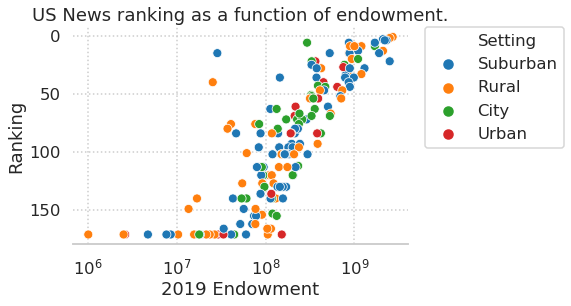

In [18]:
# Common graphing libraries
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

sns.set_style("whitegrid",{'axes.spines.left' : False,
                           'axes.spines.right': False,
                           'axes.spines.top': False,
                           'grid.linestyle': ':'})
sns.set_context("talk")

g = sns.scatterplot(data=uni_df,x='2019 Endowment',y='Ranking',hue="Setting")
g.invert_yaxis()
g.set(xscale='log',title="US News ranking as a function of endowment.")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
None